In [2]:
from sklearn.datasets import load_breast_cancer, load_boston, load_diabetes, load_digits, load_iris, load_linnerud, load_wine
#                                    C                R              R            C           C            R            C
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as data
import matplotlib.pyplot as plt

In [41]:
class FFN(nn.Module):
    def __init__(self, n_neurons: list, n_output: int, if_classification: str):
        '''
        Feed-forward нейросеть-классификатор с функциями активации ReLU. К выходному нейрону применяется сигмоида.

        n_neurons: list - Количество нейронов в каждом слое кроме выходного
        '''
        super().__init__()
        self.n_neurons = n_neurons
        self.if_classification = if_classification
        
        layers: list[nn.Module] = []

        for n_in, n_out in zip(n_neurons[:-1], n_neurons[1:]):
            layers.append(nn.Linear(n_in, n_out))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(n_neurons[-1], n_output))

        self.linear = nn.Sequential(*layers)
        if if_classification == 'C':
            if n_output > 1:
                self.output = nn.Softmax(dim=1)
            else:
                self.output = nn.Sigmoid()

    def forward(self, x: torch.tensor):
        x = self.linear(x)
        if self.if_classification == 'C':
            x = self.output(x)
        return x

    # Под мёртвыми нейронами мы будем подразумевать нейроны, которые на всех входных данных после ReLU выдают 0
    # Поэтому мы положим, что выходной нейрон (с сигмоидой, если он вообще есть) всегда немёртвый
    def dead_neurons(self, x: torch.tensor):
        '''
        x: batch_size x shape

        return: массив тензоров. Каждый элемент тензора соответствует одному нейрону и показывает степень 
            "мёртвости" нейрона - долю объектов, для вычисления предсказания которых нейрон не используется. 
            0 - нейрон используется при вычислении предсказания для каждого элемента выборки x. 
            1 - нейрон не используется никогда
        '''
        inactive = []
        for layer in self.linear:
            x = layer(x)
            if type(layer) == nn.ReLU:
                # Если после ReLU нейрон выход нейрона равен 0, то он не используется
                ia = (x == torch.zeros(x.shape)).float()
                inactive += [torch.mean(ia, dim=0)]
        return inactive

                        

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

datasets = [
    load_breast_cancer(return_X_y=True), 
    load_boston(return_X_y=True),
    load_diabetes(return_X_y=True),
    load_digits(return_X_y=True),
    load_iris(return_X_y=True),
    load_linnerud(return_X_y=True),
    load_wine(return_X_y=True)
]

tasks = ['C', 'R', 'R', 'C', 'C', 'R', 'C']
outputs = [1, 1, 1, 10, 3, 3, 3]
names = ['Рак груди', 'Цены на жильё', 'Диабет', 'Цифры', 'Ирисы', 'Упражнения', 'Вино']

X_train, X_test, y_train, y_test = [], [], [], []
X_all = []

for i, (X, y) in enumerate(datasets):
    X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y)

    X_all.append(torch.tensor(X - np.mean(X, axis=0)).float())
    X_train.append(torch.tensor(X_train0 - np.mean(X_train0, axis=0)).float())
    X_test.append(torch.tensor(X_test0 - np.mean(X_test0, axis=0)).float())
    
    if tasks[i] == 'C' and outputs[i] > 1:
        y_train.append(torch.tensor(np.eye(outputs[i])[y_train0]).float())
        y_test.append(torch.tensor(np.eye(outputs[i])[y_test0]).float())
    else:
        y_train.append(torch.tensor(y_train0).float())
        y_test.append(torch.tensor(y_test0).float())


/home/fedor/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing datas

In [11]:
from tqdm import trange

def train_model(model: nn.Module, optimizer: torch.optim, 
        X: torch.Tensor, y: torch.Tensor, num_epochs: int, 
        loss_function, alpha=0.0, regul=None, verbose=True, scheduler=None):
    graph = []

    model.train()

    if verbose:
        rng = trange(num_epochs)
    else:
        rng = range(num_epochs)

    for _ in rng:
        y_pred: torch.Tensor = model(X).squeeze()
        if regul is None:
            loss = loss_function(y_pred, y)
        else:
            loss = loss_function(y_pred, y) + alpha * regul(model.parameters())
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        graph.append(float(loss.item()))
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
    return graph

def eval_model(model: nn.Module, X: torch.Tensor, y: torch.Tensor, loss_function, alpha=0.0, regul=None, task='C'):
    model.eval()
    y_pred: torch.Tensor = model(X).squeeze()
    loss = loss_function(y_pred, y).item()
    if regul is not None:
        loss += alpha * regul(model.parameters())
    if task == 'C':
        acc = torch.mean((torch.abs(y_pred - y) < 0.5).float()).item()
    else:
        std = np.std(np.array(y))
        acc = torch.mean((torch.abs(y_pred - y) < 2 * std).float()).item()
    return loss, acc

Общие замечания:

1. В этой работе будем исследовать число мёртвых нейронов на наборе данных breast cancer при помощи нейросети с 30 входами (потому что у нас 30 входных признаков), 3 скрытыми слоями по 15, 10 и 5 нейронов (потому что с одной стороны, нейросеть должна качественно обучаться и быть хоть капельку deep (не забываем название предмета), с другой - не тратить на обучение слишком много времени) и выходным слоем, содержащем число нейронов, равное число выходов (для классификации с k классами - соответственно k).

2. Из-за того, что все активации - это ReLU, при неудачной инициализации может получиться так, что на всех входных данных нейросеть будет выдавать одинаковые значения, не обучаться (и показывать стабильное качество). Если центрировать все признаки (сделать их средние равными 0), то такое событие будет возникать сильно реже. Для того, чтобы избежать, на графиках (и, соответственно, в выводах) учитываются только модели с разумным качеством. Также модели с необоснованно низким качеством могут возникать, например, в силу неудачного выбора оптимизатора или слишком большой регуляризации. И в этих случаях не будем рассматривать эти модели, поскольку эти модели не решают исходную задачу.

3. Для обучения нейросети будет применяться метод градиентного спуска (не стохастического!), поскольку в обучающей выборке содержится очень немного объектов.

4. Можно заметить, что во всех задачах датасет "Диабет" стоит особняком - слишком много мёртвых нейронов. Это связано с тем, что это несколько более лёгкий (т.е. качество на нём немного выше, чем на всех остальных) датасет по сравнению с остальными (например, благодаря тому, что надо предсказывать всего одну переменную) и поэтому на нём в сравнении с другими датасетами доля мёртвых нейронов выше при той же структуре нейросети. Поскольку сравнивать разные нейросети было бы некорректно, все сравнения проводились в равных условиях и результаты получились такие, какие получились.


---

1. Зависимость от слоя

100%|██████████| 50/50 [01:10<00:00,  1.40s/it]


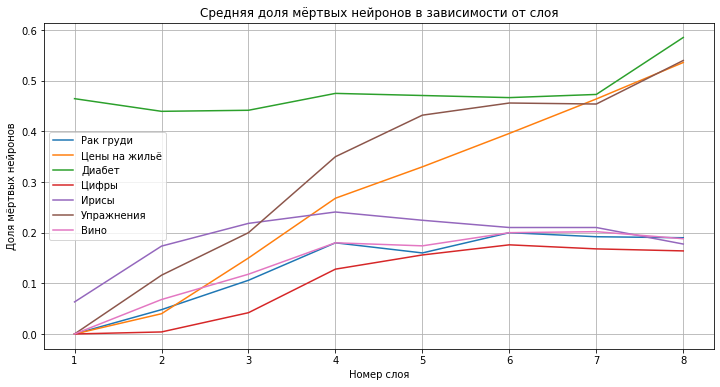

In [44]:
N_ITER = 50

plt.figure(figsize=(12, 6))
plt.title('Средняя доля мёртвых нейронов в зависимости от слоя')
plt.xlabel('Номер слоя')
plt.ylabel('Доля мёртвых нейронов')

for k in range(7):
    n_dead_neurons = np.zeros((N_ITER, 8))
    successfully_optimised = np.zeros((N_ITER, 8)).astype('bool')
    for i in trange(N_ITER):
        ffn = FFN([X_train[k].shape[1], 10, 10, 10, 10, 10, 10, 10, 10], outputs[k], if_classification=tasks[k])

        train_model(ffn, torch.optim.Adam(ffn.parameters()), X_train[k], y_train[k], 1000, nn.MSELoss(), verbose=False)
        # Добавляем только нормально обучившиеся модели
        prec = eval_model(ffn, X_test[k], y_test[k], nn.MSELoss(), task=tasks[k])[1]
        if prec > 0.85:
            successfully_optimised[i] = True
            n_dead_neurons[i] = torch.tensor([sum(x == 1.0) for x in ffn.dead_neurons(X_all[k])])

    mean = n_dead_neurons.mean(axis=0, where=successfully_optimised) / 10
    plt.plot(torch.arange(1, 9), mean, label=names[k])

plt.grid()
plt.legend()
plt.show()

Вывод: при приближении к выходному слою нейроны в среднем становятся менее полезными, поскольку на поздних слоях с большей вероятностью возникает такая ситуация, что на предыдущих слоях нейросети уже есть вся необходимая информация для конструирования ответа - в таких случаях, по сути, нам достаточно двух нейронов на слое, чтобы передать информацию дальше: $x = ReLU(x) - ReLU(-x) \quad \forall x$. Стоит отметить, что при достижении некоторого числа слоёв (для каждого датасета - своего) происходит "насыщение" и доля мёртвых нейронов остаётся постоянной

---

2. Зависимость от глубины

100%|██████████| 20/20 [03:03<00:00,  9.16s/it]


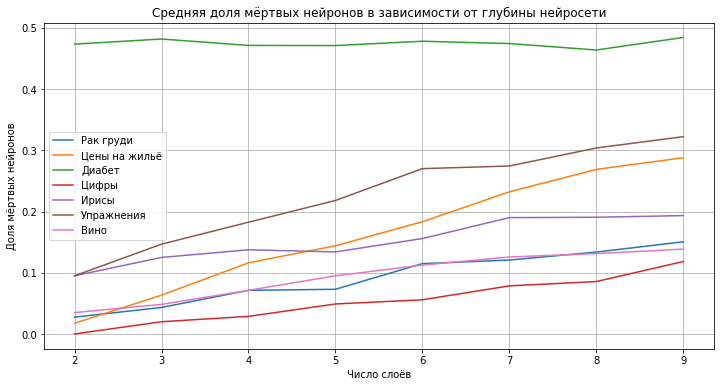

In [45]:
N_ITER_2 = 20

plt.figure(figsize=(12, 6))
plt.title('Средняя доля мёртвых нейронов в зависимости от глубины нейросети')
plt.xlabel('Число слоёв')
plt.ylabel('Доля мёртвых нейронов')

for k in range(7):
    n_dead_neurons_2 = np.zeros((N_ITER_2, 8))

    successfully_optimised_2 = np.zeros((N_ITER_2, 8)).astype('bool')
    precision_2 = np.zeros((N_ITER_2, 8))
    for i in trange(N_ITER_2):
        for j in range(2, 10):
            ffn = FFN([X_train[k].shape[1]] + [10]*j, outputs[k], tasks[k])  # Классификатор с j (скрытыми) слоями по 10 нейронов и 1 выходным с 1 нейроном

            train_model(ffn, torch.optim.Adam(ffn.parameters()), X_train[k], y_train[k], 1000, nn.MSELoss(), verbose=False)
            # Добавляем только нормально обучившиеся модели
            prec = eval_model(ffn, X_test[k], y_test[k], nn.MSELoss(), task=tasks[k])[1]
            if prec > 0.85:
                successfully_optimised_2[i, j-2] = 1
                precision_2[i, j-2] = prec
                n_dead_neurons_2[i, j-2] = sum([sum(x == 1.0) for x in ffn.dead_neurons(X_all[k])])

    mean_2 = n_dead_neurons_2.mean(axis=0, where=successfully_optimised_2) / np.arange(20, 100, 10)
    plt.xticks(np.arange(2, 10))
    plt.plot(np.arange(2, 10), mean_2, label=names[k])

plt.grid()
plt.legend()
plt.show()

Результаты соответствуют здравому смыслу - чем больше мы добавляем нейронов (слоёв), тем с большей вероятностью он "не пригодится", поскольку чем больше нейронов в нейросети, тем вероятнее, что она уже и без этого обучается достаточно качественно.

---

3. Зависимость от ширины

100%|██████████| 20/20 [01:44<00:00,  5.23s/it]
/tmp/ipykernel_10849/2067446277.py:25: RuntimeWarning: Mean of empty slice.
  mean_3 = n_dead_neurons_3.mean(axis=0, where=successfully_optimised_3) / np.arange(9, 63, 9)
/home/fedor/.local/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 20/20 [01:22<00:00,  4.11s/it]
/tmp/ipykernel_10849/2067446277.py:25: RuntimeWarning: Mean of empty slice.
  mean_3 = n_dead_neurons_3.mean(axis=0, where=successfully_optimised_3) / np.arange(9, 63, 9)
/home/fedor/.local/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 20/20 [01:22<00:00,  4.11s/it]


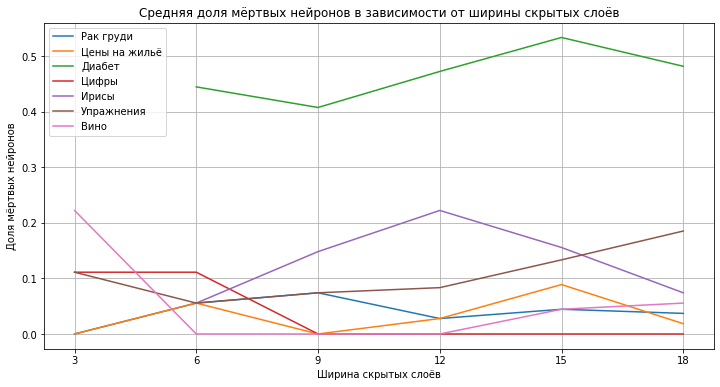

In [46]:
N_ITER_3 = 20

plt.figure(figsize=(12, 6))
plt.title('Средняя доля мёртвых нейронов в зависимости от ширины скрытых слоёв')
plt.xlabel('Ширина скрытых слоёв')
plt.ylabel('Доля мёртвых нейронов')

for k in range(7):
    for i in trange(N_ITER_3):
        n_dead_neurons_3 = np.zeros((N_ITER_3, 6))

        successfully_optimised_3 = np.zeros((N_ITER_3, 6)).astype('bool')
        precision_3 = np.zeros((N_ITER_3, 6))
        for j in range(1, 7):
            ffn = FFN([X_train[k].shape[1]] + [3*j, 3*j, 3*j], outputs[k], tasks[k])  # Классификатор с j (скрытыми) слоями по 10 нейронов и 1 выходным с 1 нейроном

            train_model(ffn, torch.optim.Adam(ffn.parameters()), X_train[k], y_train[k], 1000, nn.MSELoss(), verbose=False)
            # Добавляем только нормально обучившиеся модели
            prec = eval_model(ffn, X_test[k], y_test[k], nn.MSELoss(), task=tasks[k])[1]
            if prec > 0.85:
                successfully_optimised_3[i, j-1] = 1
                precision_3[i, j-1] = prec
                n_dead_neurons_3[i, j-1] = sum([sum(x == 1.0) for x in ffn.dead_neurons(X_all[k])])
    
    mean_3 = n_dead_neurons_3.mean(axis=0, where=successfully_optimised_3) / np.arange(9, 63, 9)
    plt.xticks(np.arange(3, 21, 3))
    plt.plot(np.arange(3, 21, 3), mean_3, label=names[k])

plt.grid()
plt.legend()
plt.show()

---

4. Зависимость от инициализации.

100%|██████████| 20/20 [01:21<00:00,  4.05s/it]


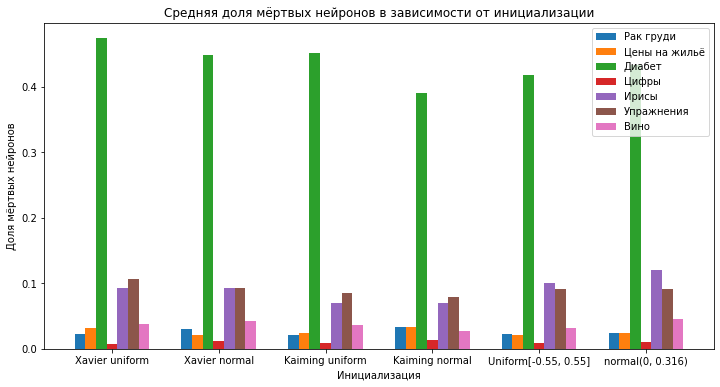

In [154]:
N_ITER_4 = 20

plt.figure(figsize=(12, 6))
plt.title('Средняя доля мёртвых нейронов в зависимости от инициализации')
plt.xlabel('Инициализация')
plt.ylabel('Доля мёртвых нейронов')

for k in range(7):
    n_dead_neurons_4 = np.zeros((N_ITER_4, 6))

    successfully_optimised_4 = np.zeros((N_ITER_4, 6)).astype('bool')
    precision_4 = np.zeros((N_ITER_4, 6))
    for i in trange(N_ITER_4):
        for j in range(6):
            ffn = FFN([X_train[k].shape[1], 15, 10, 5], outputs[k], tasks[k])

            for layer in ffn.linear:
                if type(layer) == nn.Linear:
                    if j == 0:
                        # При xavier-инициализации в каждом слое различная дисперсия
                        nn.init.xavier_uniform_(layer.weight)  # E(w) = 0, D(w) = 0.044, 0.08, 0.13, 0.16
                        nn.init.uniform_(layer.bias, -0.55, 0.55)  # E(w) = 0, D(w) = 0.1
                    elif j == 1:
                        # При xavier-инициализации в каждом слое различная дисперсия
                        nn.init.xavier_normal_(layer.weight)  # E(w) = 0, D(w) = 0.044, 0.08, 0.13, 0.16
                        nn.init.normal_(layer.bias, 0, 0.316)  # E(w) = 0, D(w) = 0.1
                    elif j == 2:
                        # При kaiming-инициализации в каждом слое различная дисперсия
                        nn.init.kaiming_uniform_(layer.weight)  # E(w) = 0, D(w) = 0.033, 0.066, 0.1, 0.2
                        nn.init.uniform_(layer.bias, -0.55, 0.55)  # E(w) = 0, D(w) = 0.1
                    elif j == 3:
                        # При kaiming-инициализации в каждом слое различная дисперсия
                        nn.init.kaiming_normal_(layer.weight)  # E(w) = 0, D(w) = 0.033, 0.066, 0.1, 0.2
                        nn.init.normal_(layer.bias, 0, 0.316)  # E(w) = 0, D(w) = 0.1
                    elif j == 4:
                        nn.init.uniform_(layer.weight, -0.55, 0.55)  # E(w) = 0, D(w) = 0.1
                        nn.init.uniform_(layer.bias, -0.55, 0.55)  # E(w) = 0, D(w) = 0.1
                    else:
                        nn.init.normal_(layer.weight, 0, 0.316)  # E(w) = 0, D(w) = 0.1
                        nn.init.normal_(layer.bias, 0, 0.316)  # E(w) = 0, D(w) = 0.1

            # При инициализации kaiming сходится дольше и хуже
            ts = train_model(ffn, torch.optim.Adam(ffn.parameters()), X_train[k], y_train[k], 1000, nn.MSELoss(), verbose=False)
            # Добавляем только нормально обучившиеся модели
            prec = eval_model(ffn, X_test[k], y_test[k], nn.MSELoss(), task=tasks[k])[1]
            if prec > 0.85:
                successfully_optimised_4[i, j] = 1
                precision_4[i, j] = prec
                n_dead_neurons_4[i, j] = sum([sum(x == 1.0) for x in ffn.dead_neurons(X_all[k])])
    
    mean_4 = n_dead_neurons_4.mean(where=successfully_optimised_4, axis=0) / 30
    plt.xticks(np.arange(6), ['Xavier uniform', 'Xavier normal', 'Kaiming uniform', 'Kaiming normal', 'Uniform[-0.55, 0.55]', 'normal(0, 0.316)'])
    plt.bar(x=np.arange(6) + 0.1*k - 0.3, height=mean_4, width=0.1, label=names[k])

plt.legend()
plt.show()

Таким образом, доля мёртвых нейронов зависит от инициализации, но:
1. Не очень существенно
2. Необъяснимым образом
3. В любом случае мёртвых нейронов очень мало

---

5. Зависимость от оптимизатора

100%|██████████| 7/7 [02:42<00:00, 23.23s/it]


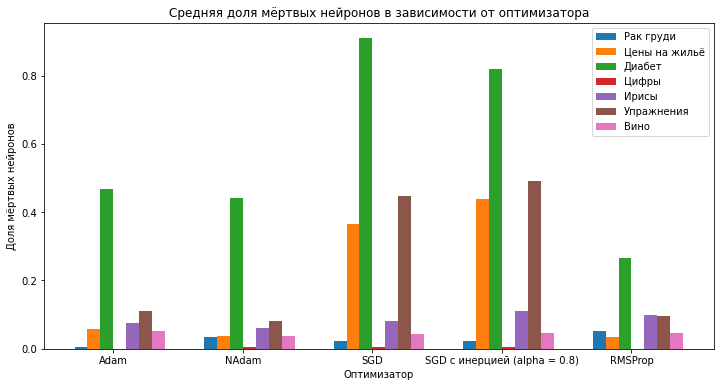

In [48]:
N_ITER_5 = 7 

iterations = [1000, 1000, 20000, 20000, 1000]

plt.figure(figsize=(12, 6))
plt.title('Средняя доля мёртвых нейронов в зависимости от оптимизатора')
plt.xlabel('Оптимизатор')
plt.ylabel('Доля мёртвых нейронов')

for k in range(7):
    n_dead_neurons_5 = np.zeros((N_ITER_5, 5))

    successfully_optimised_5 = np.zeros((N_ITER_5, 5)).astype('bool')
    precision_5 = np.zeros((N_ITER_5, 5))
    
    for i in trange(N_ITER_5):
        for j in range(5):
            ffn = FFN([X_train[k].shape[1], 15, 10, 5], outputs[k], tasks[k])  # 
            optimisers = [
                torch.optim.Adam(ffn.parameters()),
                torch.optim.NAdam(ffn.parameters()),
                torch.optim.SGD(ffn.parameters(), lr=0.003, momentum=0.0),
                torch.optim.SGD(ffn.parameters(), lr=0.003, momentum=0.8),
                torch.optim.RMSprop(ffn.parameters(), lr=0.0005)
            ]
            optimiser = optimisers[j]
            
            # Используем так много итераций, потому что не все методы успевают сойтись за те же 1000 итераций, что и Adam, который использовался всюду ранее
            train_model(ffn, optimiser, X_train[k], y_train[k], iterations[j], nn.MSELoss(), verbose=False) 
            # Добавляем только нормально обучившиеся модели
            prec = eval_model(ffn, X_test[k], y_test[k], nn.MSELoss(), task=tasks[k])[1]
            if prec > 0.85:  
                successfully_optimised_5[i, j] = 1
                precision_5[i, j] = prec
                n_dead_neurons_5[i, j] = sum([sum(x == 1.0) for x in ffn.dead_neurons(X_all[k])])
    mean_5 = n_dead_neurons_5.mean(where=successfully_optimised_5, axis=0) / 30
    plt.xticks(np.arange(5), ['Adam', 'NAdam', 'SGD', 'SGD с инерцией (alpha = 0.8)', 'RMSProp'])
    plt.bar(x=np.arange(5) + 0.1*k - 0.25, height=mean_5, width=0.1, label=names[k])

plt.legend()
plt.show()

Определить зависимость между методом оптимизации и долей мёртвых нейронов не представляется возможным. 

Иногда метод оптимизации не влияет на долю мёртвых нейронов (датасет "Ирисы"), несмотря на то, что при разных методах имеет место сходимость к различным минимумам, иногда - влияет очень существенно (так, в датасете цен на жильё разница между методами оптимизации может достигать 8 раз). На датасете с вином больше мёртвых нейронов при сходимости методом Adam, на датасетах с упражнениями и ценами на жильё - при сходимости при помощи SGD с инерцией, на датасете с раком груди - при SGD без инерции. 

---

6. Зависимость от программатора (скедулера)

100%|██████████| 20/20 [02:16<00:00,  6.83s/it]


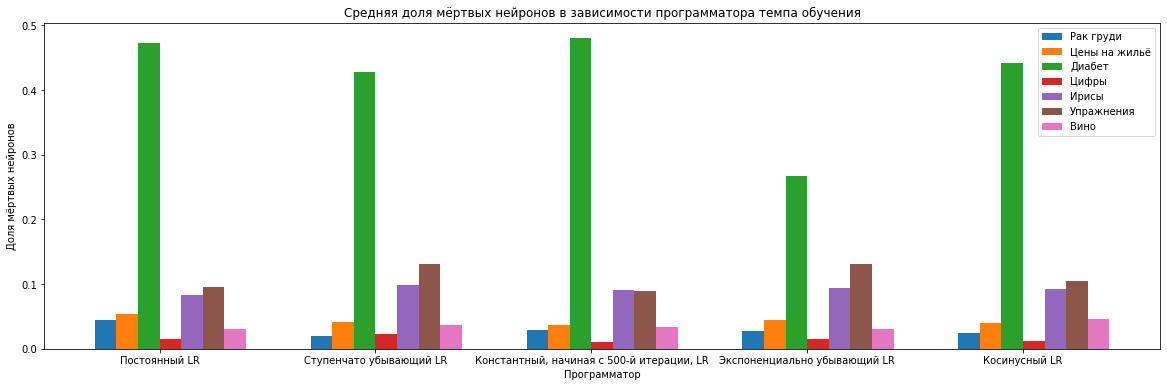

In [17]:
N_ITER_6 = 20

plt.figure(figsize=(20, 6))
plt.title('Средняя доля мёртвых нейронов в зависимости программатора темпа обучения')
plt.xlabel('Программатор')
plt.ylabel('Доля мёртвых нейронов')

for k in range(7):
    n_dead_neurons_6 = np.zeros((N_ITER_6, 5))

    successfully_optimised_6 = np.zeros((N_ITER_6, 5)).astype('bool')
    precision_6 = np.zeros((N_ITER_6, 5))
    for i in trange(N_ITER_6):
        for j in range(5):
            ffn = FFN([X_train[k].shape[1], 15, 10, 5], outputs[k], tasks[k])  # 
            optimiser = torch.optim.Adam(ffn.parameters())
            schedulers = [
                torch.optim.lr_scheduler.ConstantLR(optimiser, factor=1.0, total_iters=0),
                torch.optim.lr_scheduler.StepLR(optimiser, step_size=300, gamma=0.8),
                torch.optim.lr_scheduler.LinearLR(optimiser, start_factor=0.5, total_iters=500),
                torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.999),
                torch.optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=100)
            ]

            scheduler = schedulers[j]
            
            train_model(ffn, optimiser, X_train[k], y_train[k], 2000, nn.MSELoss(), verbose=False, scheduler=scheduler) 
            # Добавляем только нормально обучившиеся модели
            prec = eval_model(ffn, X_test[k], y_test[k], nn.MSELoss(), task=tasks[k])[1]
            if prec > 0.85:  
                successfully_optimised_6[i, j] = 1
                precision_6[i, j] = prec
                n_dead_neurons_6[i, j] = sum([sum(x == 1.0) for x in ffn.dead_neurons(X_all[k])])

    mean_6 = n_dead_neurons_6.mean(where=successfully_optimised_6, axis=0) / 30
    plt.xticks(np.arange(5), ['Постоянный LR', 'Ступенчато убывающий LR', 'Константный, начиная с 500-й итерации, LR',
        'Экспоненциально убывающий LR', 'Косинусный LR'])
    plt.bar(x=np.arange(5) + 0.1*k - 0.25, height=mean_6, width=0.1, label=names[k])

plt.legend()
plt.show()

Видно, что программатор оказывает не очень существенное влияение на долю мёртвых нейронов - отличия в качестве между различными датасетами сильнее, чем различия в качестве между различными программаторами.

Примечание: до этого я проводил несколько иные эксперименты с программаторами и пришёл к выводу, что чем ниже точность, тем больше мёртвых нейронов (это очевидно, поскольку меньшее количество нейронов может обеспечить худшую точность). Тем не менее, эти эксперименты не вошли в отчёт, поскольку цель отчёта - исследовать обученные нейросети, а не те, которые недообучились из-за неправильно подобранного программатора.

Примечание 2: по этой же причине было увеличено число итераций - оказалось, что некоторые программаторы не в состоянии сойтись за 1000 итераций.

---

7. Зависимость от регуляризации

In [18]:
def L2(params):
    l2 = 0.0
    for param in params:
        l2 += torch.sum(param ** 2)
    return l2

def L1(params):
    l1 = 0.0
    for param in params:
        l1 += torch.sum(torch.abs(param))
    return l1

100%|██████████| 10/10 [01:24<00:00,  8.47s/it]
/tmp/ipykernel_10849/1684064936.py:23: RuntimeWarning: Mean of empty slice.
  mean_7_L2 = n_dead_neurons_7_L2.mean(axis=0, where=successfully_optimised_7_L2) / 30
/home/fedor/.local/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 10/10 [01:24<00:00,  8.43s/it]
/tmp/ipykernel_10849/1684064936.py:23: RuntimeWarning: Mean of empty slice.
  mean_7_L2 = n_dead_neurons_7_L2.mean(axis=0, where=successfully_optimised_7_L2) / 30
/home/fedor/.local/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


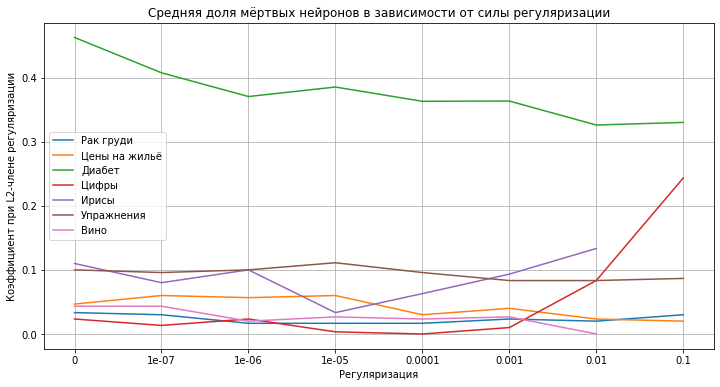

In [35]:
N_ITER_7_L2 = 10

l2_coeff = [0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

plt.figure(figsize=(12, 6))
plt.title('Средняя доля мёртвых нейронов в зависимости от силы регуляризации')
plt.xlabel('Коэффициент при L2-члене регуляризации')
plt.ylabel('Доля мёртвых нейронов')
for k in range(7):
    n_dead_neurons_7_L2 = np.zeros((N_ITER_7_L2, 8))

    successfully_optimised_7_L2 = np.zeros((N_ITER_7_L2, 8)).astype('bool')
    for i in trange(N_ITER_7_L2):
        for j in range(8):
            ffn = FFN([X_train[k].shape[1], 15, 10, 5], outputs[k], tasks[k])  
                
            train_model(ffn, torch.optim.Adam(ffn.parameters()), X_train[k], y_train[k], 1000, nn.MSELoss(), verbose=False, alpha=l2_coeff[j], regul=L2)
            # Добавляем только нормально обучившиеся модели
            if eval_model(ffn, X_test[k], y_test[k], nn.MSELoss(), task=tasks[k])[1] > 0.85:  
                successfully_optimised_7_L2[i, j] = 1
                n_dead_neurons_7_L2[i, j] = sum([sum(x == 1.0) for x in ffn.dead_neurons(X_all[k])])
    
    mean_7_L2 = n_dead_neurons_7_L2.mean(axis=0, where=successfully_optimised_7_L2) / 30
    plt.xticks(np.arange(8), l2_coeff)
    plt.plot(np.arange(8), mean_7_L2, label=names[k])

plt.grid()
plt.legend()
plt.show()

100%|██████████| 10/10 [02:16<00:00, 13.64s/it]
/tmp/ipykernel_10849/3945129568.py:25: RuntimeWarning: Mean of empty slice.
  mean_7_L1 = n_dead_neurons_7_L1.mean(axis=0, where=successfully_optimised_7_L1.astype('bool')) / 30
/home/fedor/.local/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 10/10 [01:55<00:00, 11.53s/it]
/tmp/ipykernel_10849/3945129568.py:25: RuntimeWarning: Mean of empty slice.
  mean_7_L1 = n_dead_neurons_7_L1.mean(axis=0, where=successfully_optimised_7_L1.astype('bool')) / 30
/home/fedor/.local/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 10/10 [01:46<00:00, 10.61s/it]
/tmp/ipykernel_10849/3945129568.py:25: RuntimeWarning: Mean of empty slice.
  mean_7_L1 = n_dead_neurons_7_L1.mean(axis=0, where=successfully_optimised_7_L1.astype('bool')) / 30
/home/fedo

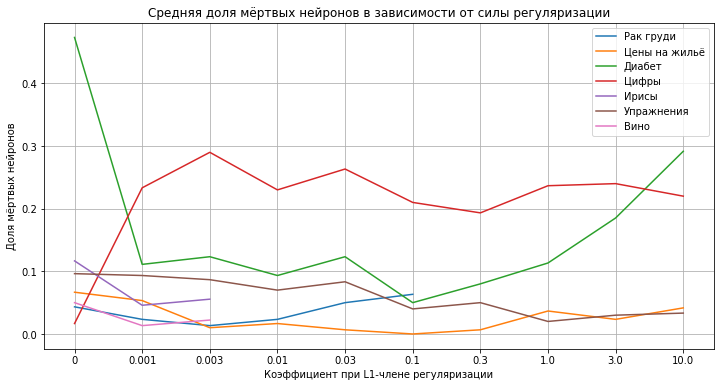

In [51]:
N_ITER_7_L1 = 10

l1_coeff = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]

plt.figure(figsize=(12, 6))
plt.title('Средняя доля мёртвых нейронов в зависимости от силы регуляризации')
plt.xlabel('Коэффициент при L1-члене регуляризации')
plt.ylabel('Доля мёртвых нейронов')

for k in range(7):
    n_dead_neurons_7_L1 = np.zeros((N_ITER_7_L1, 10))

    successfully_optimised_7_L1 = np.zeros((N_ITER_7_L1, 10)).astype('bool')
    for i in trange(N_ITER_7_L1):
        for j in range(10):
            ffn = FFN([X_train[k].shape[1], 15, 10, 5], outputs[k], tasks[k])  # Классификатор с 6 (скрытыми) слоями по 10 нейронов и 1 выходным с 1 нейроном
                
            train_model(ffn, torch.optim.Adam(ffn.parameters()), X_train[k], y_train[k], 1000, nn.MSELoss(), verbose=False, alpha=l1_coeff[j], regul=L1)
            # Добавляем только нормально обучившиеся модели
            prec = eval_model(ffn, X_test[k], y_test[k], nn.MSELoss(), task=tasks[k])[1]
            if prec > 0.85:  
                successfully_optimised_7_L1[i, j] = 1
                n_dead_neurons_7_L1[i, j] = sum([sum(x == 1.0) for x in ffn.dead_neurons(X_all[k])])

    mean_7_L1 = n_dead_neurons_7_L1.mean(axis=0, where=successfully_optimised_7_L1.astype('bool')) / 30
    plt.xticks(np.arange(10), l1_coeff)
    plt.plot(np.arange(10), mean_7_L1, label=names[k])

plt.grid()
plt.legend()
plt.show()

Из двух предыдущих графиков видно, что регуляризация либо не влияет на долю мёртвых нейронов, либо влияет, но не всегда. Было бы логичным предположить, что в среднем чем больше коэффициент регуляризации, тем больше мёртвых доля нейронов, поскольку, как известно, L1-регуляризатор зануляет веса, оказывающие малое влияние на функцию потерь, а чем больше занулённых весов, тем больше и мёртвых нейронов, так как нейрон со всеми нулевыми весами всегда мёртв ($ReLU(x_1 * 0 + ... + x_n * 0 + 0) = 0$ для любых $x_i$). Тем не менее, это можно наблюдать только для одного датасета, у остальных - нейросеть перестаёт качественно решать задачу раньше, чем увеличится доля мёртвых нейронов.